# Лабораторная работа 5. Рекомендации по формализации и расчетам характеристик подсистем КИС в виде разомкнутых или замкнутых стохастических моделей
## Задание 1

Для одноканальной системы массового обслуживания с ограничением на длину
очереди $m$ составьте дифференциальные уравнения для вероятностей нахождения
в заданных состояниях в зависимости от времени. Найдите эти вероятности при
определенном в соответствии с вариантом значении $t$, а также при $t
\xrightarrow{} \infty$. Канал иногда может выходить из строя. Заявка, которая
обслуживается в момент отказа канала ставится в очередь, если там есть места,
в противном случае она покидает систему необслуженной. Входящий поток, поток
обслуживания, поток отказов и поток восстановления простейшие
с соответствующими интенсивностями $\lambda, \mu, \nu, \gamma$. Количество
клиентов, от которых могут поступать заявки на обслуживание $k$. Начальные
условия $P_0(0) = 1$.

In [1]:
Variant <- 5
set.seed(Variant)
m <- sample(c(4:18), 1)

mu <- runif(1)

lambda <- runif(1)
if (lambda > mu) {
    current <- lambda
    lambda <- mu
    mu <- current
}

gamma <- runif(1)

nu <- runif(1)

if (gamma < nu) {
    current <- nu
    nu <- gamma
    gamma <- current
}

if (sample(c(0:1), 1)) {
    k <- sample(c(4:7), 1)
} else {
    k <- "inf"
}
t <- runif(1)
View(data.frame(lambda, mu, nu, gamma, k, m, t))

lambda,mu,nu,gamma,k,m,t
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
0.6852186,0.9168758,0.1046501,0.2843995,inf,5,0.52796


Введем следующие состояния:
- $S_0$ - нет выполняемых задач, СМО готова выполнять внешние задачи;
- $S_1$ - СМО занята выполнением внешней задачи, очереди нет;
- $S_2$ - СМО занята выполнением внешней задачи, в очереди одна задача;
- ...
- $S_m$ - СМО занята выполнением внешней задачи, в очереди $m$ задач;
- $S_{m+1}$ - СМО вышла из строя, в очереди нет задач;
- $S_{m+2}$ - СМО вышла из строя, в очереди одна задача;
- ...
- $S_{2m}$ - СМО вышла из строя, в очереди m задач.

Тогда граф состояний будет выглядеть:
![graph](./State_graph.png)
В бирюзовом кластере находятся состояния, когда СМО в рабочем состоянии.
В зеленом - когда вышла из строя.

### Теоретически

По графу составим уравнения Колмогорова:
$$
\begin{cases}
\frac{dP_0(t)}{dt} = -(\lambda + \nu)P_0(t) + \mu\cdot P_1(t) + \gamma \cdot P_6(t) \\
\frac{dP_1(t)}{dt} = -(\lambda + \nu + \mu)P_1(t) + \lambda \cdot P_0(t) + \mu \cdot P_2(t) + \gamma \cdot P_7(t) \\
\frac{dP_2(t)}{dt} = -(\lambda + \nu + \mu)P_2(t) + \lambda \cdot P_1(t) + \mu \cdot P_3(t) + \gamma \cdot P_8(t) \\
\frac{dP_3(t)}{dt} = -(\lambda + \nu + \mu)P_3(t) + \lambda \cdot P_2(t) + \mu \cdot P_4(t) + \gamma \cdot P_9(t) \\
\frac{dP_4(t)}{dt} = -(\lambda + \nu + \mu)P_4(t) + \lambda \cdot P_3(t) + \mu \cdot P_5(t) + \gamma \cdot P_{10}(t) \\
\frac{dP_5(t)}{dt} = -(\nu + \mu)P_5(t) + \lambda \cdot P_4(t) \\
\frac{dP_6(t)}{dt}  = -(\gamma + \lambda)P_6(t) + \nu \cdot P_0(t) \\
\frac{dP_7(t)}{dt}  = -(\gamma + \lambda)P_7(t) + \lambda \cdot P_6(t) + \nu \cdot P_1(t) \\
\frac{dP_8(t)}{dt}  = -(\gamma + \lambda)P_8(t) + \lambda \cdot P_7(t) + \nu \cdot P_2(t) \\
\frac{dP_9(t)}{dt}  = -(\gamma + \lambda)P_9(t) + \lambda \cdot P_{8}(t) + \nu \cdot P_3(t) \\
\frac{dP_{10}(t)}{dt} = -\gamma \cdot P_{10}(t) + \lambda \cdot P_{9}(t) + \nu \cdot P_4(t) + \nu \cdot P_5(t)
\end{cases}
$$

и уравнение нормировки:
$$
P_0(t) + P_1(t) + P_2(t) + P_3(t) + P_4(t) + P_5(t) + P_6(t) + P_7(t) + P_8(t) + P_9(t) + P_{10}(t) = 1
$$

Решим эти уравнения с помощью пакета deSolve
(см. 75 стр. [документации](chrome-extension://gfbliohnnapiefjpjlpjnehglfpaknnc/pages/pdf_viewer.html?r=https://cran.r-project.org/web/packages/deSolve/deSolve.pdf)):

In [2]:
if (!require("deSolve")) {
    install.packages("deSolve")
}
library(deSolve)

ode_system_equations <- function(Time, State, Pars) {
    with(as.list(c(State, Pars)), {
        dP_0 <- -(lambda + nu) * abs(P_0) + mu * abs(P_1) + gamma * abs(P_6)
        dP_1 <- -(lambda + nu + mu) * abs(P_1) + lambda * abs(P_0) + mu * abs(P_2) + gamma * abs(P_7)
        dP_2 <- -(lambda + nu + mu) * abs(P_2) + lambda * abs(P_1) + mu * abs(P_3) + gamma * abs(P_8)
        dP_3 <- -(lambda + nu + mu) * abs(P_3) + lambda * abs(P_2) + mu * abs(P_4) + gamma * abs(P_9)
        dP_4 <- -(lambda + nu + mu) * abs(P_4) + lambda * abs(P_3) + mu * abs(P_5) + gamma * abs(P_10)
        dP_5 <- -(nu + mu) * abs(P_5) + lambda * abs(P_4)
        dP_6 <- -(gamma + lambda) * abs(P_6) + nu * abs(P_0)
        dP_7 <- -(gamma + lambda) * abs(P_7) + lambda * abs(P_6) + nu * abs(P_1)
        dP_8 <- -(gamma + lambda) * abs(P_8) + lambda * abs(P_7) + nu * abs(P_2)
        dP_9 <- -(gamma + lambda) * abs(P_9) + lambda * abs(P_8) + nu * abs(P_3)
        dP_10 <- -gamma * abs(P_10) + lambda * abs(P_9) + nu * abs(P_4) + nu * abs(P_5)
        norm <- P_0 + P_1 + P_2 + P_3 + P_4 + P_5 + P_6 + P_7 + P_8 + P_9 + P_10

        # Specifying list of derivatives.
        return(
            list(c(
                dP_0,
                dP_1,
                dP_2,
                dP_3,
                dP_4,
                dP_5,
                dP_6,
                dP_7,
                dP_8,
                dP_9,
                dP_10,
                norm
            ))
        )
    })
}

Loading required package: deSolve



Уравнение нормировки в данном пакете задать напрямую нельзя, оно будет
восприниматься как дифференциальное уравнение. Однако если его упустить,
значения $P_i$ будут выходить за пределы $[0, 1]$.

Также, если его оставить и задать в начальных условиях равным 1, оно все
равно будет постепенно расти до $\infty$, дестабилизируя при этом $P_i$ (
они тоже будут выходить за адекватные пределы).
#
Поэтому было принято решение оставить уравнение нормировки как
дифференциальное, воспользовавшись при этом дополнительным параметром
`events`, позволяющим задать частичные частные решения в любой момент
времени. Так, "обнуляя" значение уравнения нормировки до 1 каждые 10 тактов,
мы стабилизируем результаты вычисления системы ОДУ: по таблице `output`
видно, что переменная `norm` часто становится выше 1, однако значения
$P_i$ все равно находятся в $[0, 1]$ и их сумма равна 1. Именно этого
мы и добивались.

In [3]:
pars <- NULL
yini <- c(
    P_0 = 1,
    P_1 = 0,
    P_2 = 0,
    P_3 = 0,
    P_4 = 0,
    P_5 = 0,
    P_6 = 0,
    P_7 = 0,
    P_8 = 0,
    P_9 = 0,
    P_10 = 0,
    norm = 1
)


INITIAL_TIME <- 0
FINISH_TIME <- 100000

norm_equation_values <- data.frame(
    var = "norm",
    time = INITIAL_TIME:FINISH_TIME,
    value = 1,
    method = "replace"
)

ACCURACY <- 0.1
times <- seq(INITIAL_TIME, FINISH_TIME, by = ACCURACY)
output <- ode(yini, times, ode_system_equations, pars, events = list(data = norm_equation_values))
output

time,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,norm
0.0,1.0000000,0.00000000,0.000000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000000,0.0000000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0
0.1,0.9270084,0.06063537,0.002045108,4.623144e-05,7.949466e-07,1.159128e-08,0.009594107,0.0006474643,2.196934e-05,5.045980e-07,9.213937e-09,1.1
0.2,0.8645223,0.10785777,0.007151111,3.211848e-04,1.088585e-05,3.047119e-07,0.017628670,0.0023424160,1.579731e-04,7.146389e-06,2.517036e-07,1.2
0.3,0.8106585,0.14459610,0.014120992,9.425447e-04,4.766322e-05,2.002470e-06,0.024342663,0.0047761009,4.793075e-04,3.236144e-05,1.717179e-06,1.3
0.4,0.7639109,0.17312185,0.022115513,1.948312e-03,1.305754e-04,7.357061e-06,0.029936163,0.0077083425,1.022837e-03,9.161672e-05,6.547082e-06,1.4
0.5,0.7230684,0.19520195,0.030554070,3.328571e-03,2.770569e-04,1.960784e-05,0.034577372,0.0109529793,1.801278e-03,2.006222e-04,1.810328e-05,1.5
0.6,0.6871557,0.21220990,0.039045083,5.046033e-03,5.006250e-04,4.270890e-05,0.038407936,0.0143670135,2.810504e-03,3.736578e-04,4.087937e-05,1.6
0.7,0.6553782,0.22522544,0.047326194,7.051839e-03,8.101864e-04,8.094831e-05,0.041547993,0.0178405849,4.035882e-03,6.224601e-04,8.028611e-05,1.7
0.8,0.6270932,0.23508579,0.055236675,9.290600e-03,1.210790e-03,1.386283e-04,0.044099086,0.0212914628,5.455251e-03,9.561216e-04,1.423832e-04,1.8
0.9,0.6017725,0.24245230,0.062679304,1.170943e-02,1.703488e-03,2.198611e-04,0.046147759,0.0246581354,7.042915e-03,1.380643e-03,2.336660e-04,1.9


Вычислим индекс строки, которую нужно взять для получения результата при
заданом в условии $t$:

In [4]:
PRECISION_OF_ACCURACY <- 1
t_index <- round(t, PRECISION_OF_ACCURACY) * 10^PRECISION_OF_ACCURACY + 1
t_index

[1] 6

По данному индексу имеем ближайший вектор значений:

In [5]:
results <- output[t_index, 1:12]
results

time          P_0          P_1          P_2          P_3          P_4 
5.000000e-01 7.230684e-01 1.952020e-01 3.055407e-02 3.328571e-03 2.770569e-04 
         P_5          P_6          P_7          P_8          P_9         P_10 
1.960784e-05 3.457737e-02 1.095298e-02 1.801278e-03 2.006222e-04 1.810328e-05

При $t \rightarrow{} \infty$ (взяли последний результат, брать значения $t$
выше нет смысла, так как видно, что значения $\forall P_i$ в конце таблицы
сходятся):

In [6]:
results <- output[nrow(output), 2:12]
results

P_0        P_1        P_2        P_3        P_4        P_5        P_6 
0.16544083 0.13698511 0.12285413 0.11619599 0.11344092 0.07609384 0.01785590 
       P_7        P_8        P_9       P_10 
0.02740327 0.03262515 0.03559678 0.15550808

Подтвердим, что $\sum P_i = 1$:

In [7]:
sum(results)

[1] 1

In [8]:
get_P <- function(P_index) {
    return(as.numeric(results)[1 + P_index])
}

#### Вероятность простоя
Вероятность простоя равна $P_0$:

In [9]:
get_P(0)

[1] 0.1654408

#### Вероятность образования очереди
Вероятность образования очереди $P_{\text{оч}}$ равна обратной вероятности $P_{\overline{\text{оч}}}$.
Та, в свою очередь, равна сумме вероятностей, соответствующих состояниям,
в которых очередь пуста.
$$
P_{\text{оч}} = 1 - P_{\overline{\text{оч}}} = 1 - (P_0 + P_1 + P_{m + 1})
$$

In [10]:
1 - (get_P(0) + get_P(1) + get_P(m + 1))

[1] 0.6797182

#### Абсолютную пропускную способность
 Абсолютную пропускную способность вычислим по формуле:
$$
\lambda'=\lambda\cdot(1-P_m(t)-P_{2m}(t))
$$

In [11]:
absolute_flow_capacity <- lambda * (1 - get_P(m) - get_P(2 * m))
absolute_flow_capacity

[1] 0.5265207

#### Среднюю длину очереди
Для вычисления средней длины очереди просуммируем произведения вероятностей
на соответствующие этим вероятностям длины очередей.
$$
L_{\text{оч}} = 1 \cdot P_2(t) + 2 \cdot P_3(t) + 3 \cdot P_4(t) +
\text{...} + (m-1) \cdot P_m + 1 \cdot P_{m+2}(t) + 2 \cdot P_{m+3}(t) +
\text{...} + (m - 1) \cdot P_{2m}(t)
$$

In [12]:
# Получаем длину очереди в системе для заданного индекса вероятности.
P.get_queue_length <- function(P_index) {
    if (P_index < 1) {
        return(0)
    }

    if (P_index <= m) {
        return(P_index - 1)
    }

    return(P_index - m - 1)
}

P.get_product <- function(P_index) {
    return(get_P(P_index) * P.get_queue_length(P_index))
}

mean_length <- sum(unlist(
    lapply(c(2:m), P.get_product)
)) + sum(unlist(
    lapply(c((m + 2):(2 * m)), P.get_product)
))
mean_length

[1] 1.82142

#### Среднее время нахождения в очереди
$$
W_{\text{оч}}=\frac{L_{\text{оч}}}{\lambda'}
$$

In [13]:
W <- mean_length / absolute_flow_capacity
W

[1] 3.459352

#### Среднее число заявок в системе
Для вычисления средней длины очереди просуммируем произведения вероятностей
на соответствующие этим вероятностям значения заявок в системе
(длины очередей + количество заявок на обслуживании):
$$
L = (1 + 0) \cdot P_1(t) + (1 + 1) \cdot P_2(t) + (1 + 2) \cdot P_3(t) +
(1 + 3) \cdot P_4(t) + \text{...} + (1 + m - 1) \cdot P_m +
1 \cdot P_{m+2}(t) + 2 \cdot P_{m+3}(t) + \text{...} + (m - 1) \cdot P_{2m}(t)
$$

In [14]:
# Получаем количество заявок на обслуживании для заданного индекса вероятности.
P.get_number_of_requests_proccessed <- function(P_index) {
    if (P_index > 0 && P_index <= m) {
        return(1)
    }

    return(0)
}

P.get_product1 <- function(P_index) {
    P.number_of_requests <- P.get_queue_length(P_index) + P.get_number_of_requests_proccessed(P_index)

    return(get_P(P_index) * P.number_of_requests)
}

mean_number_of_requests <- sum(unlist(
    lapply(c(2:m), P.get_product1)
)) + sum(unlist(
    lapply(c((m + 2):(2 * m)), P.get_product1)
))
mean_number_of_requests

[1] 2.250005

#### Среднее время нахождения заявок в системе
$$
T =\frac{L}{\lambda'}
$$

In [15]:
T <- mean_number_of_requests / absolute_flow_capacity
T

[1] 4.273347

### Численно
Построим с помощью пакета simmer симуляцию системы $M/M/1/m$.

In [36]:
if (!require("simmer")) {
    install.packages("simmer")
}
library(simmer)
if (!require("simmer.plot")) {
    install.packages("simmer.plot")
}
library(simmer.plot)

MM1m.env <- simmer("SuperDuperSim")
MM1m.env

simmer environment: SuperDuperSim | now: 0 | next: 
{ Monitor: in memory }

Зададим траекторию отказа в случае полной очереди:

In [37]:
m.queue <- trajectory("clients' path") %>%
    ## add an intake activity
    seize("server", amount = 1) %>%
    timeout(function() rexp(1, 1 / mu)) %>%
    release("server", amount = 1)

Добавим симуляцию поломки системы, задав механизм смены поля $capacity$ ресурса
$server$ с 1 на 0 и обратно с интенсивностью $\gamma$ и $\nu$ соответственно.

In [38]:
# Transform intervals timetable of chronologic points.
# Example:
# 1, 2, 0.5, 0.3, 0.2 -> 1, 3, 3.5, 3.8, 4
accumulate <- function(intervals) {
    timetable <- c()

    for (interval_index in seq_along(intervals)) {
        point <- intervals[interval_index]

        if (interval_index > 1) {
            point <- point + timetable[interval_index - 1]
        }

        timetable <- append(timetable, point)
    }

    return(timetable)
}

In [39]:
create_timetable <- function(number_of_points, break_intensity, repair_intensity) {
    intervals <- c()

    for (interval_index in 1:number_of_points) {
        intensity <- break_intensity

        if (interval_index %% 2 == 0) {
            intensity <- repair_intensity
        }

        intervals <- append(intervals, rexp(1, 1 / intensity))
    }


    return(accumulate(intervals))
}

create_capacity_schedule <- function(number_of_points) {
    stopifnot(number_of_points %% 2 == 0)

    timetable <- create_timetable(
        number_of_points,
        break_intensity = gamma,
        repair_intensity = nu
    )

    capacity_sequence <- rep(c(1, 0), times = number_of_points / 2)

    period <- sum(timetable)

    return(
        schedule(
            timetable,
            capacity_sequence,
            period
        )
    )
}

capacity_schedule <- create_capacity_schedule(1000)

In [40]:
SIMULATION_TIME <- FINISH_TIME

MM1m.env %>%
    add_resource(
        "server",
        capacity = capacity_schedule,
        queue_size = m
    ) %>%
    add_generator("clients", m.queue, function() rexp(1, lambda)) %>%
    run(until = SIMULATION_TIME)

simmer environment: SuperDuperSim | now: 1e+05 | next: 100004.856308032
{ Monitor: in memory }
{ Resource: server | monitored: TRUE | server status: 0(0) | queue status: 5(5) }
{ Source: clients | monitored: 1 | n_generated: 68671 }

In [41]:
arrivals <- get_mon_arrivals(MM1m.env)
arrivals

name,start_time,end_time,activity_time,finished,replication
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
clients0,1.894917,3.981250,1.95223598,TRUE,1
clients1,2.280292,5.226341,1.19507177,TRUE,1
clients2,3.856281,5.652940,0.22588966,TRUE,1
clients3,3.998148,8.245507,2.53093032,TRUE,1
clients4,6.176005,9.706722,1.19529908,TRUE,1
clients5,13.836621,14.259539,0.07852953,TRUE,1
clients6,14.273267,16.373976,2.04613260,TRUE,1
clients7,15.285371,16.788553,0.41457659,TRUE,1
clients8,15.346418,17.581324,0.79277127,TRUE,1


Логи симуляции:

In [42]:
resources <- get_mon_resources(MM1m.env)
resources

resource,time,server,queue,capacity,queue_size,system,limit,replication
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
server,0.06545754,0,0,1,5,0,6,1
server,0.18659119,0,0,0,5,0,5,1
server,0.21142329,0,0,1,5,0,6,1
server,0.27927005,0,0,0,5,0,5,1
server,0.42287091,0,0,1,5,0,6,1
server,0.51116970,0,0,0,5,0,5,1
server,0.54886069,0,0,1,5,0,6,1
server,0.55811438,0,0,0,5,0,5,1
server,0.80895379,0,0,1,5,0,6,1


#### Вероятность простоя
Подсчитаем отношение количества состояний, когда система не загружена,
к общему количеству состояний.

In [76]:
free_states <- resources %>% subset(server == 0) %>% subset( capacity > 0)
free_states

,resource,time,server,queue,capacity,queue_size,system,limit,replication
,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,server,0.06545754,0,0,1,5,0,6,1
3,server,0.21142329,0,0,1,5,0,6,1
5,server,0.42287091,0,0,1,5,0,6,1
7,server,0.54886069,0,0,1,5,0,6,1
9,server,0.80895379,0,0,1,5,0,6,1
11,server,1.07778288,0,0,1,5,0,6,1
13,server,2.02901435,0,0,1,5,0,6,1
15,server,2.39117347,0,0,1,5,0,6,1
17,server,2.61255726,0,0,1,5,0,6,1


In [77]:
nrow(free_states) / nrow(resources)

[1] 0.1116733

#### Вероятность образования очереди
Вычислим вероятность образования очереди, подсчитав отношение количества записей,
в которых очередь не пуста, к общему количеству записей.

In [49]:
queue_unempty <- resources %>% subset(queue != 0)
queue_unempty

,resource,time,server,queue,capacity,queue_size,system,limit,replication
,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
13,server,1.894917,0,1,0,5,1,5,1
16,server,2.280292,1,1,0,5,2,5,1
17,server,2.391173,1,1,1,5,2,6,1
18,server,2.467250,1,1,0,5,2,5,1
19,server,2.612557,1,1,1,5,2,6,1
20,server,2.654605,1,1,0,5,2,5,1
21,server,3.122301,1,1,1,5,2,6,1
22,server,3.165898,1,1,0,5,2,5,1
23,server,3.531010,1,1,1,5,2,6,1


In [78]:
nrow(queue_unempty) / nrow(resources)

[1] 0.1118179

#### Абсолютную пропускную способность
 Абсолютную пропускную способность вычислим по формуле:
$$
\lambda'=\lambda\cdot(1-P_m(t)-P_{2m}(t))
$$

In [79]:
number_of_unfinished <- arrivals %>% with(sum(!finished))
number_of_unfinished

[1] 68390

In [80]:
finish_probability <- number_of_unfinished / nrow(arrivals)
finish_probability

[1] 0.995995

In [81]:
absolute_flow_capacity <- lambda * finish_probability
absolute_flow_capacity

[1] 0.6824743

#### Среднюю длину очереди

In [54]:
mean_length <- resources %>% with(mean(queue))
mean_length

[1] 1.295499

#### Среднее время нахождения в очереди
Построим график и сравним его со значением $W_\text{оч}$ (черная горизонтальная прямая), найденным теоретически:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


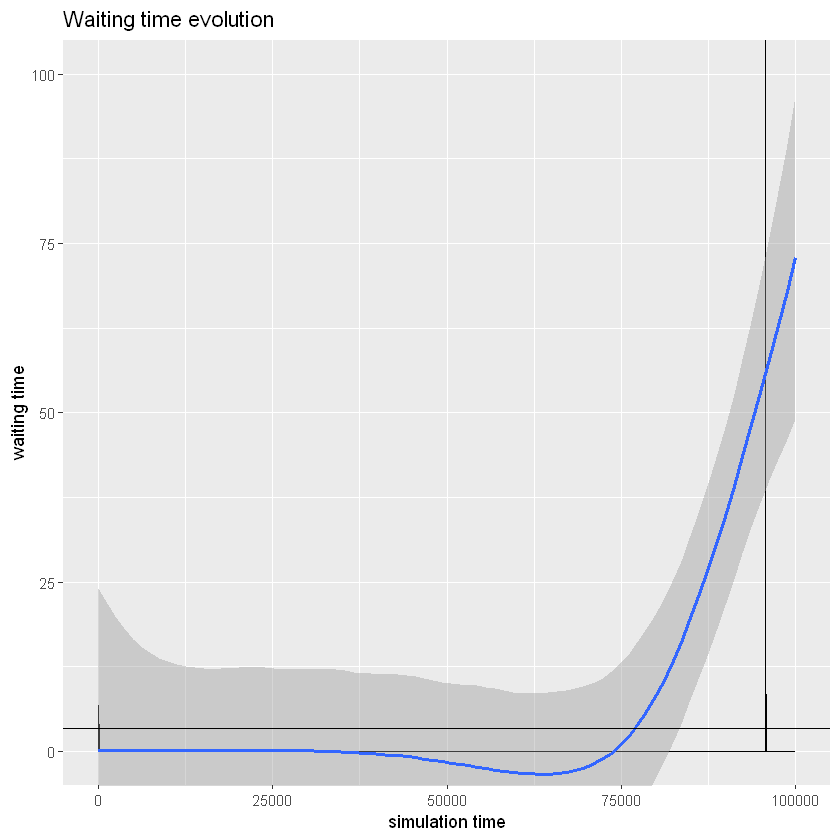

In [68]:
plot(arrivals, metric = "waiting_time", names = "server", items = "system") +
    coord_cartesian(xlim = c(0, SIMULATION_TIME), ylim = c(0, 100)) +
    geom_hline(yintercept = W)

#### Среднее число заявок в системе
Среднее число заявок в системе сравним с теоретическим, проанализируя график использования
ресурса `server`:

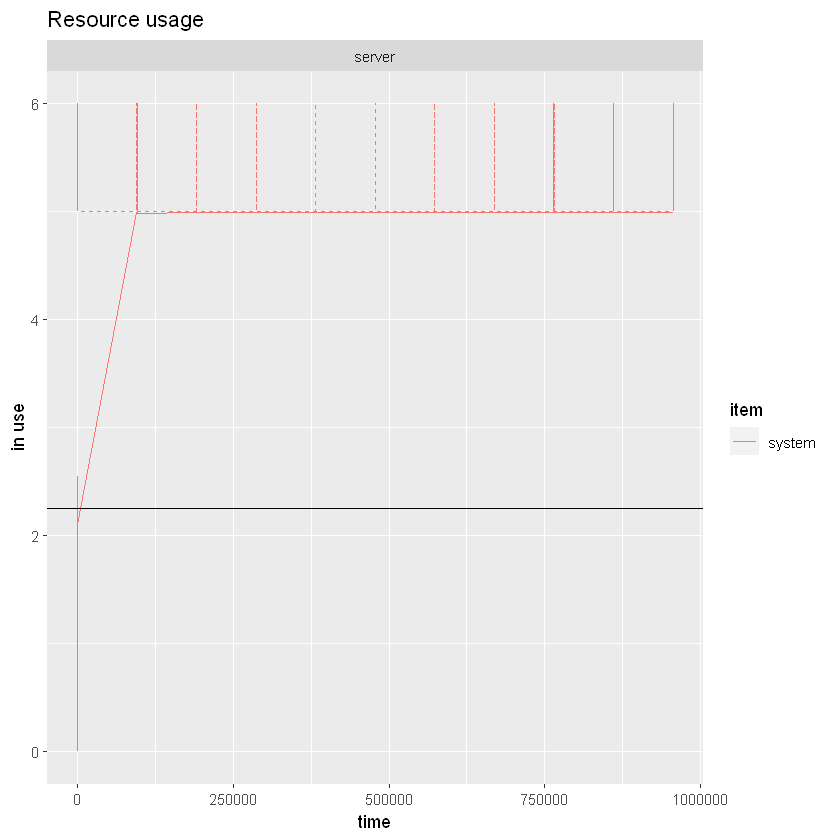

In [74]:
plot(resources, metric = "usage", names = "server", items = "system") +
    geom_hline(yintercept = mean_number_of_requests)

По этому графику сложно судить, поэтому дополнительно рассчитаем значение,
воспользовавшись таблицей использования ресурсов:

In [75]:
resources %>% with(mean(queue) + mean(server))

[1] 2.05197

#### Среднее время нахождения заявок в системе $T$
Поступим со средним временем нахождения заявок в системе $T$ по аналогии
с $W$ - сравним два графика:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


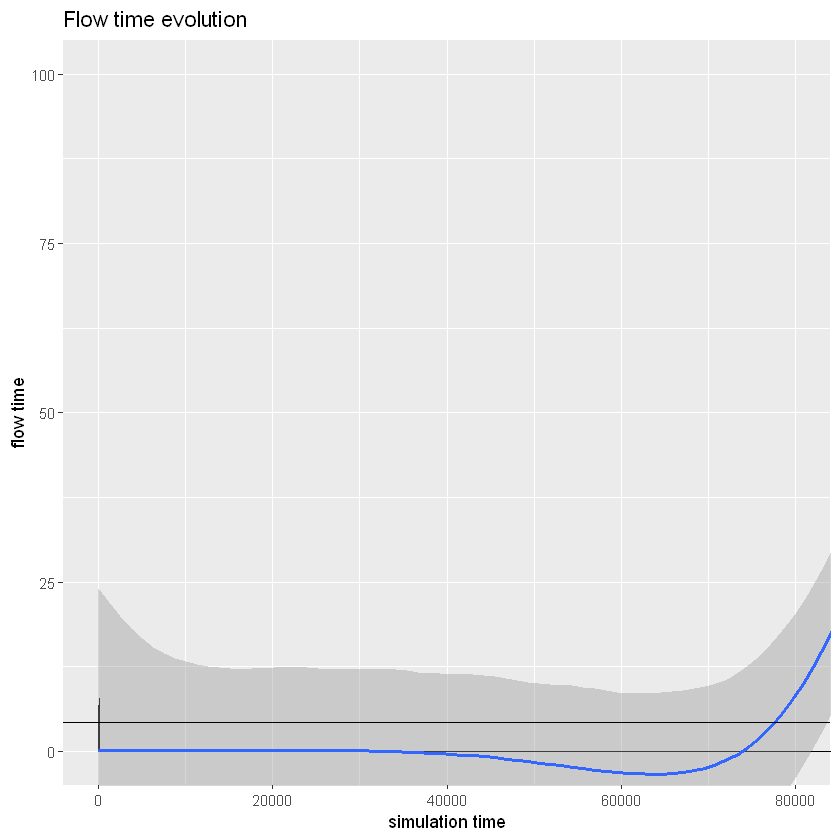

In [73]:
plot(arrivals, metric = "flow_time", names = "server", items = "system") +
    coord_cartesian(xlim = c(0, 80000), ylim = c(0, 100)) +
    geom_hline(yintercept = T)

### Выводы
Как видно, теоретически вычисленные значения с некоторой точностью совпадают
со значениями, полученным численным методом. При увеличении количества
экспериментов 𝑁 точность только увеличивается.